### Imports modules and vector fields

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
from scipy import interpolate
import PIVutils
import PODutils
import grafteaux as G
import automateG as AG
from scipy.ndimage.measurements import find_objects, label, center_of_mass
import prom2d as PP
import time


X, Y, U, V,Swirl, Cond,Prof, SwirlFiltPro, SwirlFiltRet, SwirlFilt = G.init_data()
Umean = Prof['U']

xog = X[0,:]
yog = Y[:,0]

del_x = (xog[0]-xog[1])
ar_th  = del_x*del_x*np.pi*25


current path : c:\program files\python37\python.exe
['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


0.2439601862683396


### Calculate the centers of the T2 blobs and their prominance

In [2]:
umean2  = np.array([Umean[:,0] for i in range(U.shape[1])]).T
umean2.shape

umean1 = np.mean(U, axis = 2)

In [3]:
#u2d = np.nanmean(U, axis = 2) #local - pixel mean velocity


centers = []
proms = []
areas = []
s1 = time.time()


for frame in range(len(U)):
    
    t2f = G.T2_big_mat(X, Y, U[:,:,frame]-umean1, V[:,:,frame], 2)
    
    #t2f cleaning 
    t21 = t2f.copy()
    t21[t2f<0] = 0 #only prograde 
    t21[t2f<2/np.pi/1.5] = 0 #adding some preliminary threshold 0.66%2/pi
    
    #from every frame collect centers and proms
    
    t2_obs= find_objects(label(t21)[0]) #slice objects
    t2_coms_ = center_of_mass(t21, label(t21)[0], [i+1 for i in range(len(t2_obs))]) #center of masses
    t2_coms = np.array(t2_coms_).astype(int)
    
    peaks,idmap,promap,parentmap = PP.getProminence(t21,0.01,lats=yog,\
                                                    lons=xog,\
                                                    min_area=ar_th,\
                                                    include_edge=True,\
                                                    verbose = False)
    
    print(f'Frame - {frame} done.' )
    
    cent = []
    prom = []
    aa = []
    for i in peaks.keys():
        
        prom_ = peaks[i]['prominence']
        cc = PP.getind(peaks[i]['center'],xog, yog)
        aa = peaks[i]['area']
        cc1 = (cc[1], cc[0])
        
        cent.append(cc1)
        prom.append(prom_)
    
    centers.append(cent)
    proms.append(prom)
    areas.append(aa)
    
    break
print(f'took {time.time() - s1} secs.')
#we got centers and proms

C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


Frame - 0 done.
took 942.139369726181 secs.


In [4]:
areas = [] 

for i in peaks.keys():
        aa = peaks[i]['area']
        cc1 = (cc[1], cc[0])
        areas.append(aa)

### Functions to get the half prominence regions

In [5]:


def getdims(G):
    '''
    has 1s everywhre
    and 2 at center
    returns ( by-top, by-down, bx-left, bx-right)
    '''
    
    c = np.where(G==2)
    cx, cy  = c[0][0], c[1][0]
    return (cx, len(G)-cx-1, cy, len(G[0])-cy-1)
    
def find_blobs(G, cent, prom, ratio = 0.5, verbose = True):
    '''
    G- the big field
    cent- blob center whose bounds we want
    
    Very naive implementation - can be made significantly faster
    '''
    
    #modify G with prom and ratio
    pr_th = G[cent]-prom*ratio
    G_ = G.copy()
    G_[G<=pr_th] = 0 #only regions with half prom available
    
    G_obs = find_objects(label(G_)[0])
    #print(len(G_obs))
    for i in G_obs:
        #print(i)
        test  = np.zeros(G.shape)
        test[i] = 1
        if test[cent]:
            #this blob contains the cnt
            if verbose:
                plt.figure()
                plt.imshow(test)
            plt.colorbar()
            test[cent] = 2
            dims = getdims(test[i])
            return dims
    return -1
    #indicates that the search was failure 
    #unlikelyy - probably some rounding error somewhere


### Get the extent of the half prominence region from the center

C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less_equal


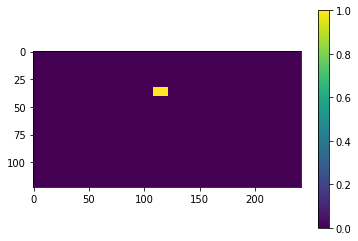

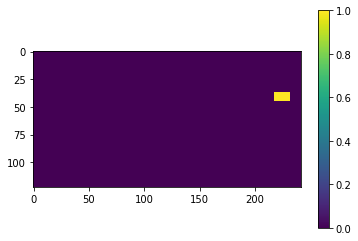

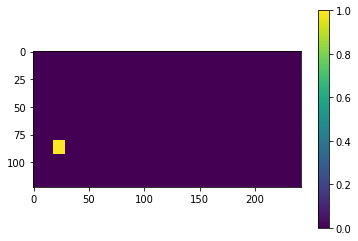

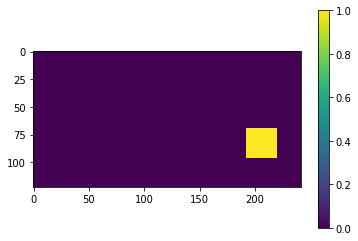

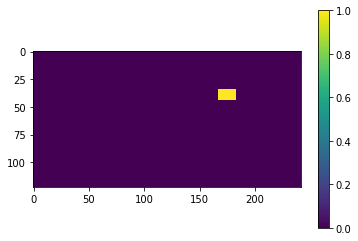

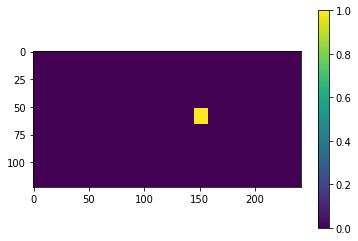

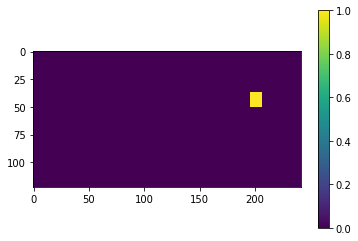

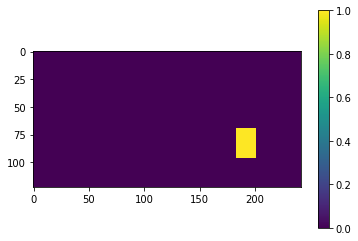

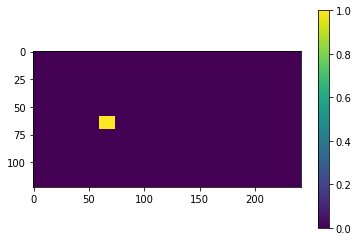

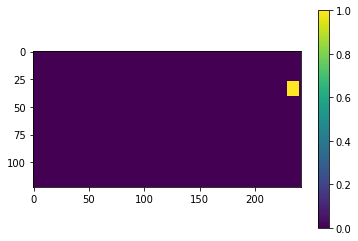

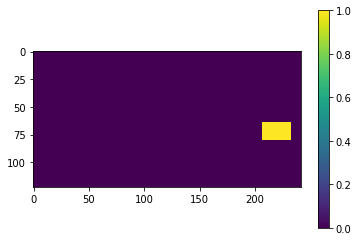

In [6]:
##bbdims array - tales centers and proms and 
#gets the half prom (or some ratio) blob regions.

bbdims = []
for i in range(len(centers)):
    #for each frame
    bbcurr = []
    #print('sdfg')
    for cf in range(len(centers[i])):
        bb_ = find_blobs(t21, centers[i][cf], proms[i][cf], ratio = 1)
        bbcurr.append(bb_)
        #print(bb_)
        #break
    bbdims.append(bbcurr)
    

### number of candidates

In [7]:
len(bbdims[0])

11

### do MCMC

In [8]:
#we have global cents, global blob dims exact, frame 
#mcmc part 

samps = []
ct = 0
for i in range(len(centers)):
    #for each frame 
    for  j in range(len(centers[i])):
        
        if bbdims[i][j] == -1 : print('bbdims fail.'); continue 
        
        print(f'working on vrtex - {ct}.')
        b1, b2, b3, b4 = bbdims[i][j]
        cy, cx = centers[i][j]
        
        #print(f'bb sizes {b1+b2 +1, b3+b4+1} .')
        
        if not (b1+b2+1) %2 : b2 +=1
        if not (b3+b4+1) %2 : b4 +=1
        
        #print(f'bb sizes {b1+b2 +1, b3+b4+1} .')
        
        uu = U[cy-b1:cy+b2+1, cx-b3:cx+b4+1,i]
        vv = V[cy-b1:cy+b2+1, cx-b3:cx+b4+1,i]
        ss = Swirl[cy-b1:cy+b2+1, cx-b3:cx+b4+1,i]
        
        uun = (uu-Umean[cy])/Cond['Uinf']
        
        #print(uu.shape)
        x1, y1  = G.get_xy_rect(uu.shape[0], uu.shape[1])
        samp_test = G.doMCMC_V4(uun, vv, x1, y1)
        #G.plot_corner(samp_test, 5000)
        samps.append(samp_test)
        print(f'vortex - {ct} done.')
        ct+=1
        
        

working on vrtex - 0.
vortex - 0 done.
working on vrtex - 1.
vortex - 1 done.
working on vrtex - 2.
vortex - 2 done.
working on vrtex - 3.
vortex - 3 done.
working on vrtex - 4.
vortex - 4 done.
working on vrtex - 5.
vortex - 5 done.
working on vrtex - 6.
vortex - 6 done.
working on vrtex - 7.
vortex - 7 done.
working on vrtex - 8.
vortex - 8 done.
working on vrtex - 9.
vortex - 9 done.
working on vrtex - 10.
vortex - 10 done.


### Plot corner plots

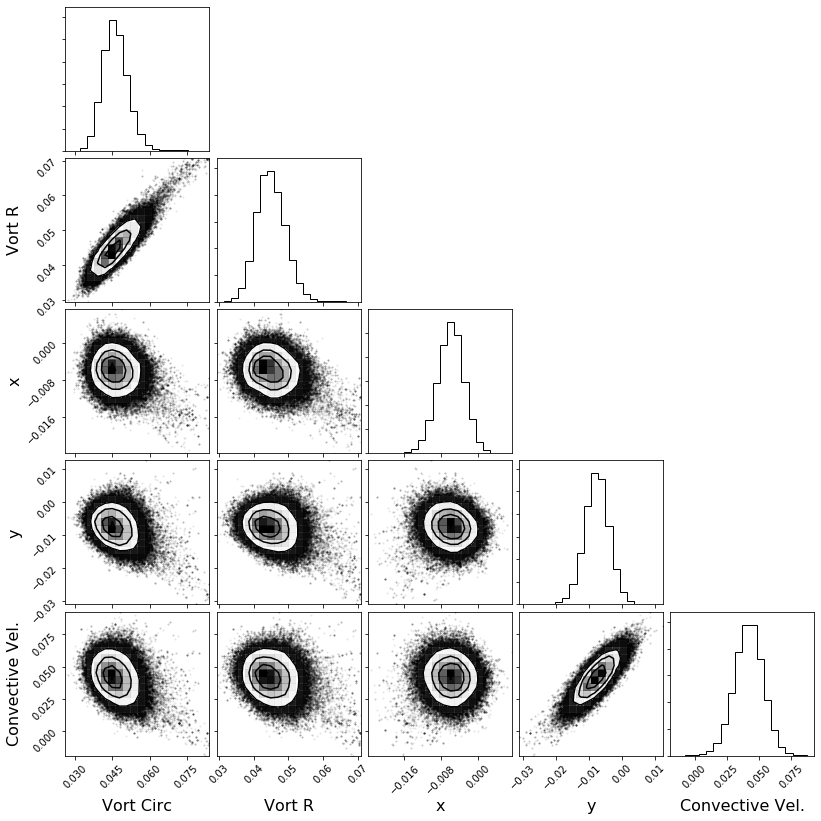

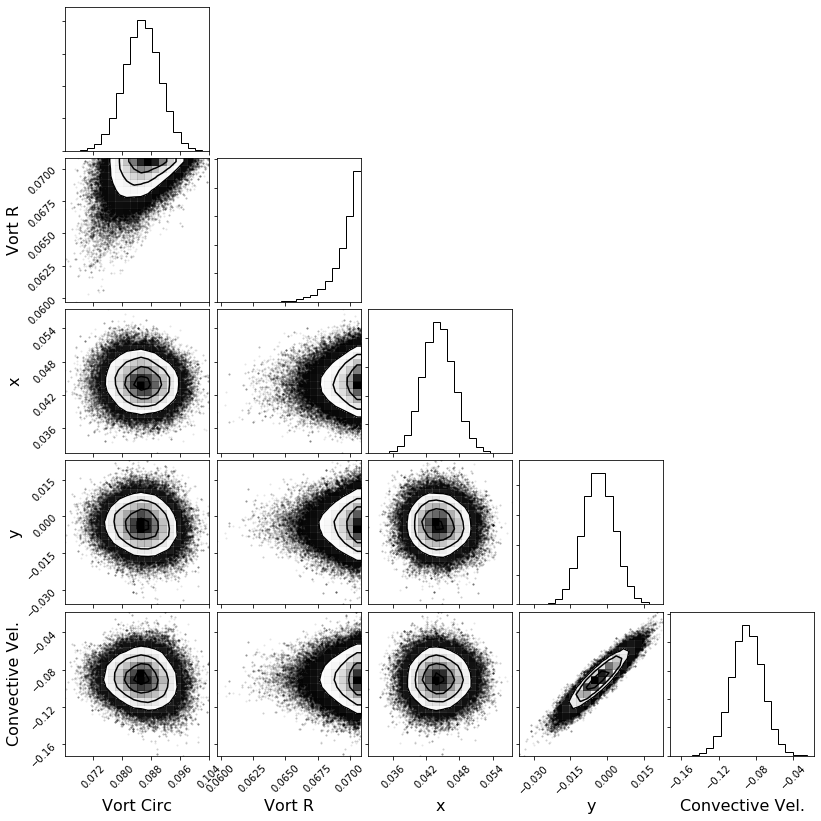

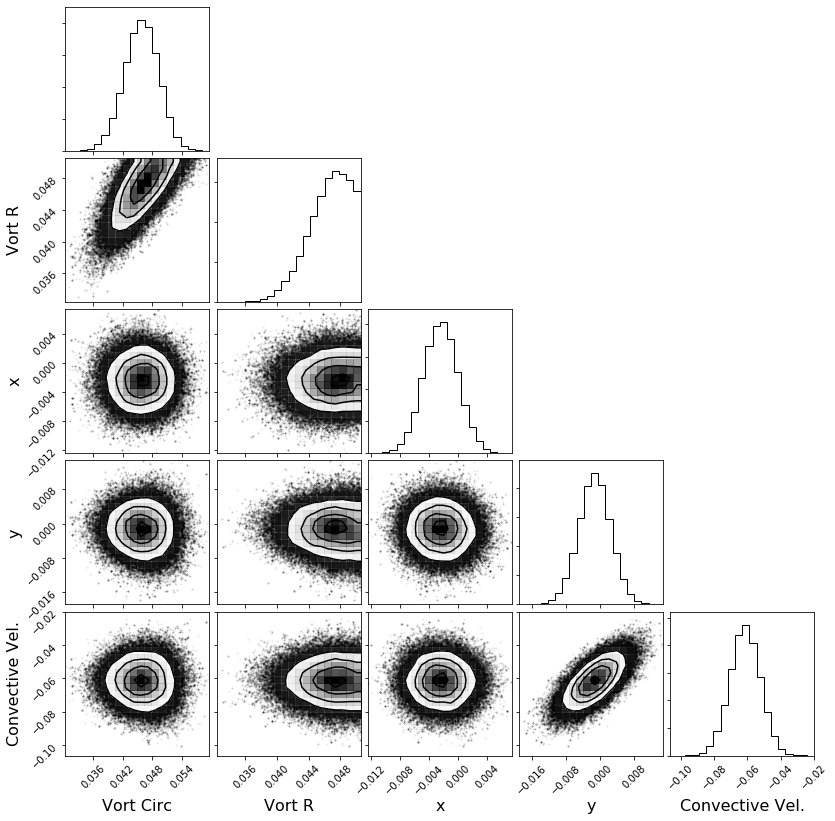

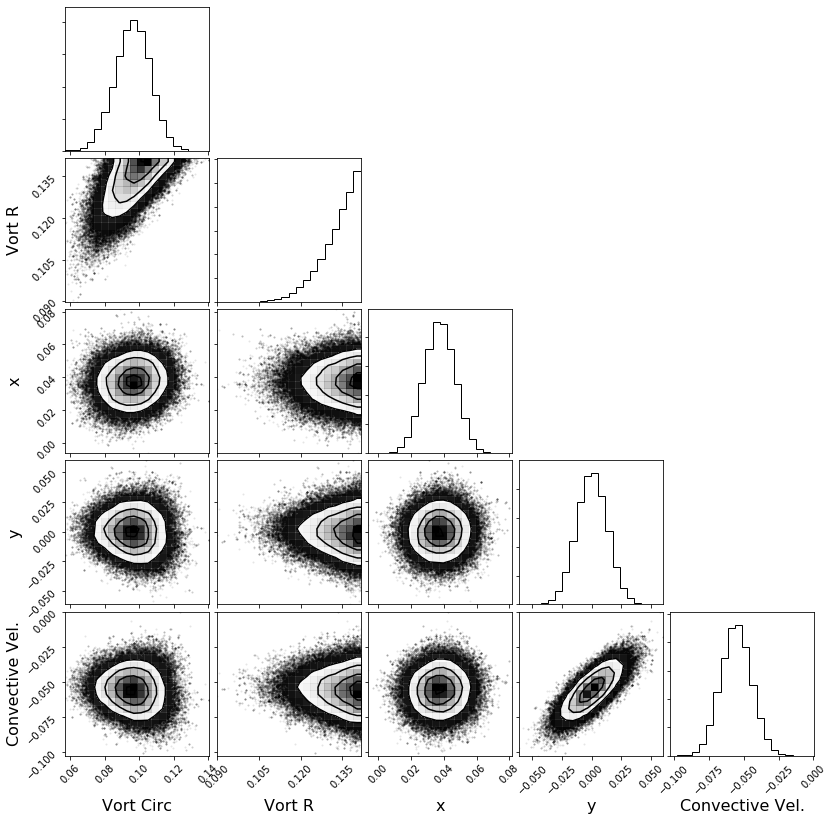

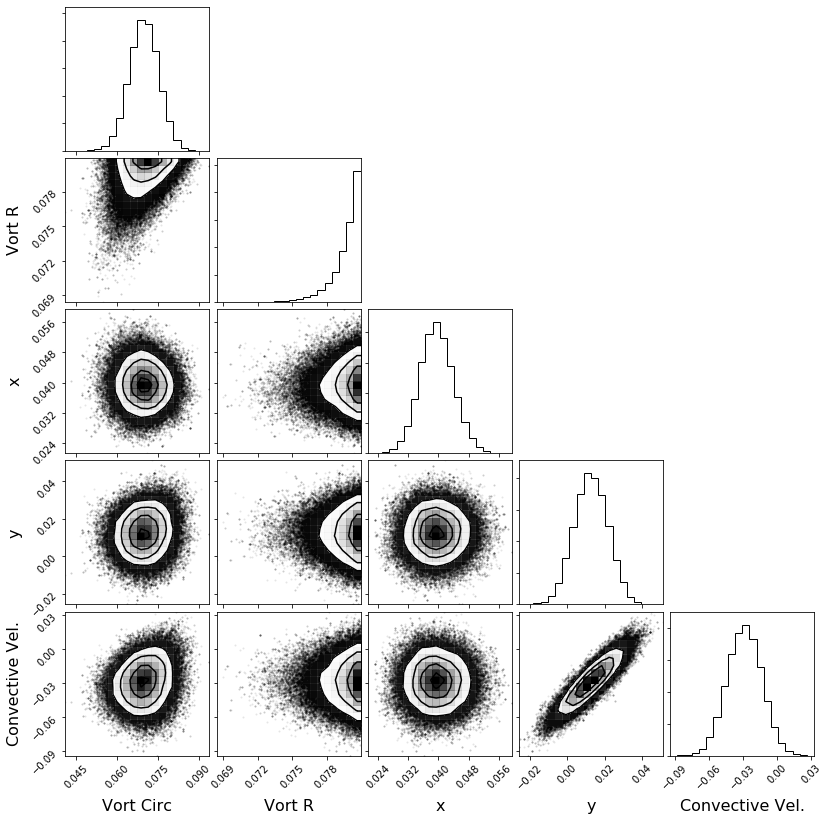

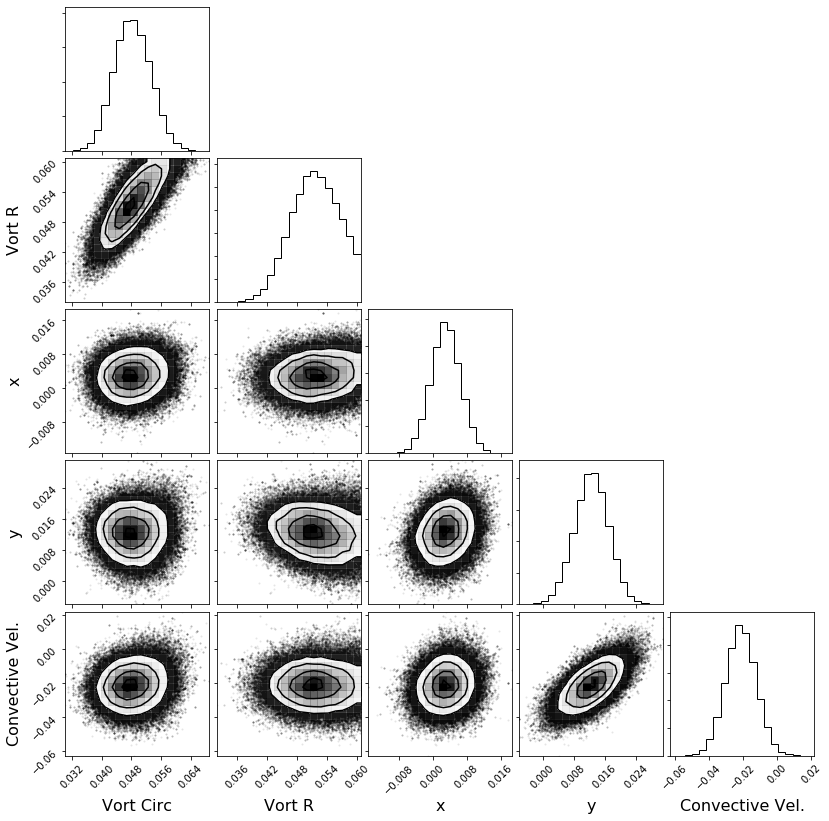

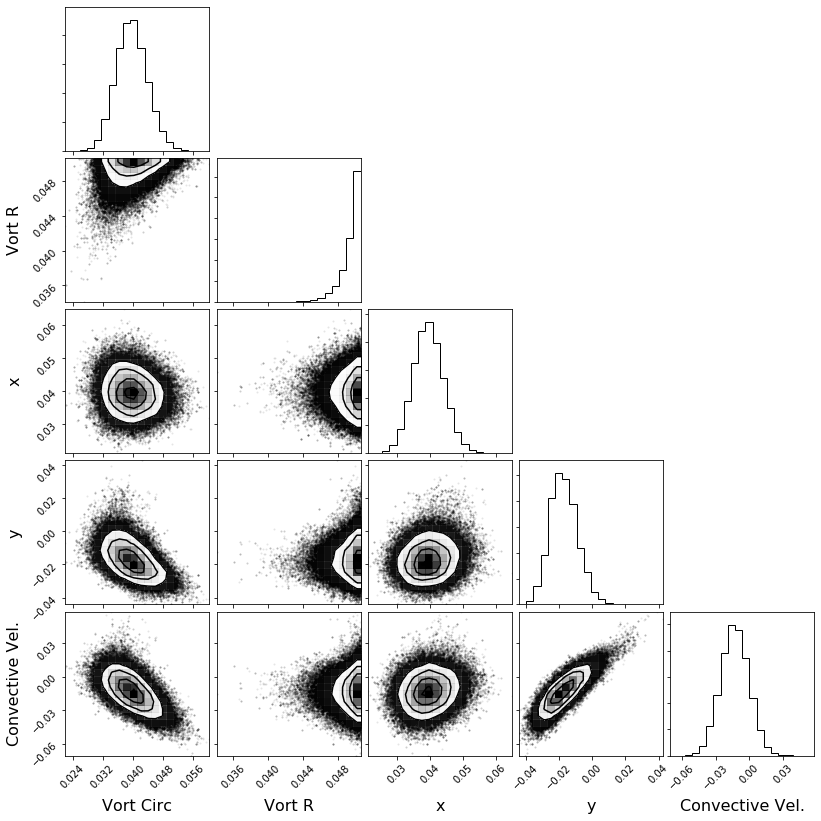

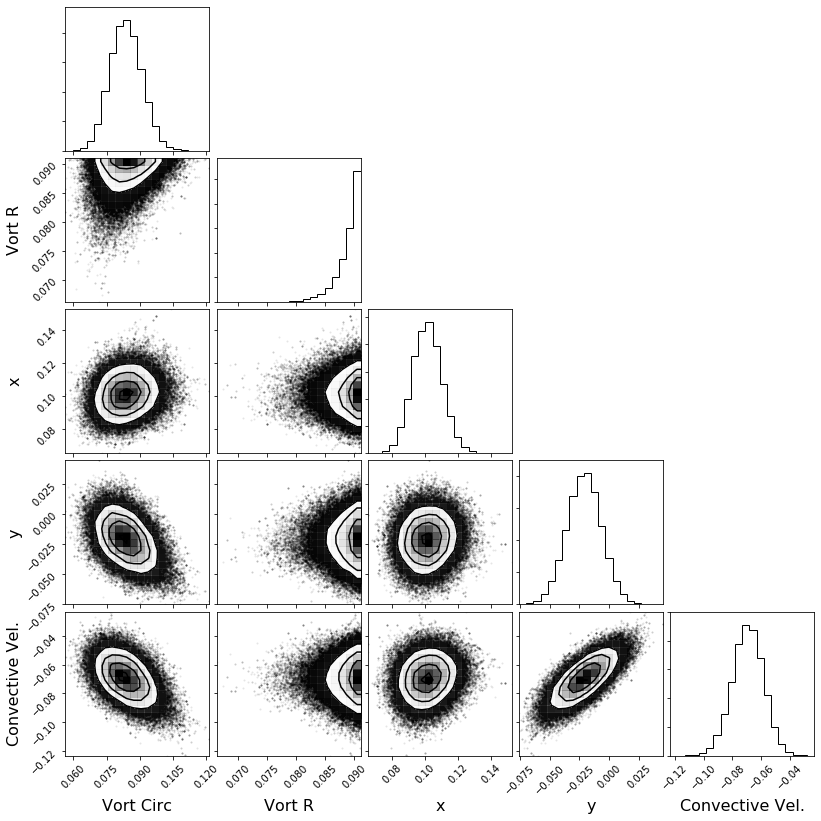

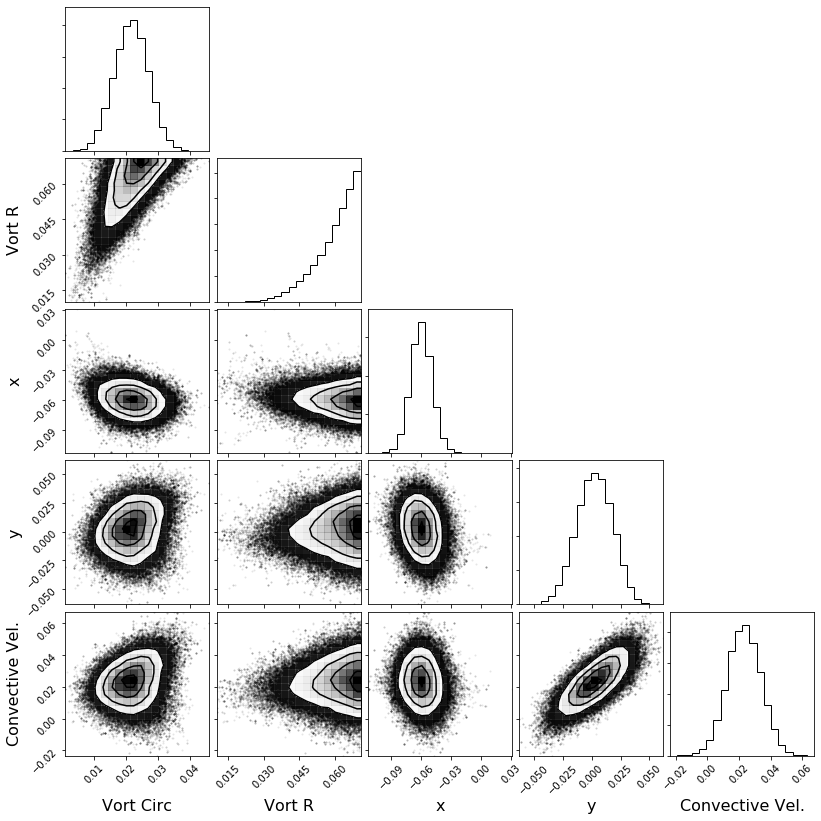

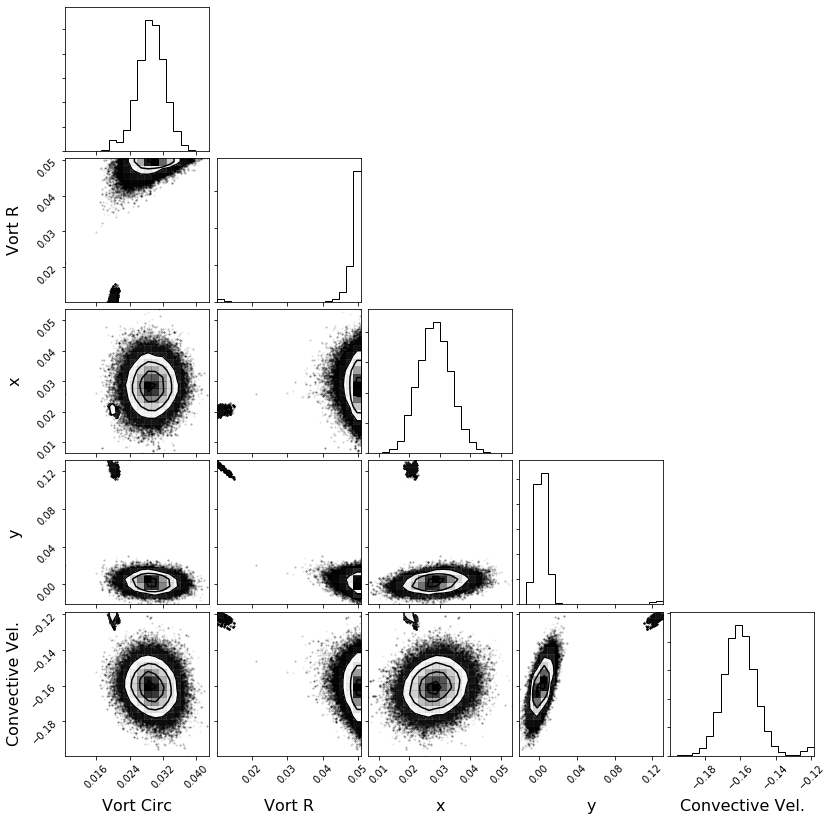

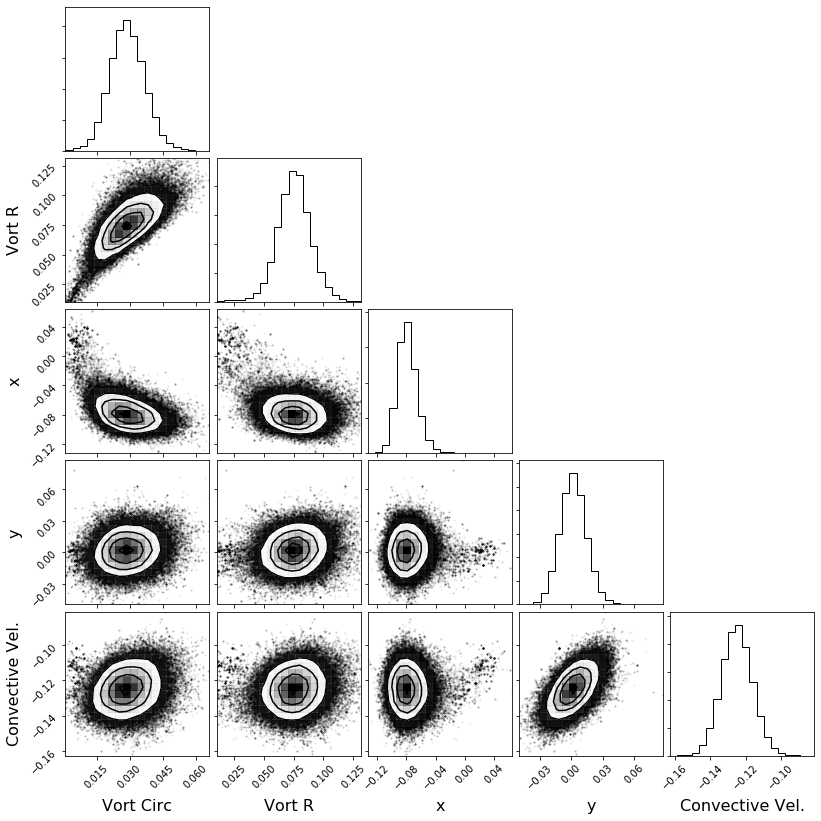

In [9]:
#prom 1.0
for samp in samps:
    G.plot_corner(samp, 5000)

In [10]:
#fail check --> corrections for F3 --> fail check -->  GMMs.

### Failure Analysis 

In [11]:
AG = reload(AG)
f3_fails = []
for i in samps:
    f3 = AG.F3check(i,5000,95)
    f3_fails.append(f3)

print(f'Success Percentage - {round(sum(f3_fails)/len(f3_fails)*100,2)} %')

Success Percentage - 63.64 %


### Corrections

In [12]:
#get props -> frame, cent, bbdims
props_list = {}
ind = 0
for i in range(len(centers)):
    
    
    for j in range(len(centers[i])):
        props_ = {}
        frame = i
        cent = centers[i][j]
        bbdim = bbdims[i][j]
        
        props_['frame'] = frame
        props_['cent'] = cent
        props_['bbdims'] = np.array(bbdim)
        props_list[ind] = props_
        ind+=1

In [13]:
for samp, si in zip(samps, range(len(samps))):
    if f3_fails[si]:
        print(f'Working on vortex {si}')
        props = props_list[si]
        samp_, _ = AG.DcorrectionV3(Cond, U, V, Umean, props, samp)
        if _: samps[si] = samp_
        

Working on vortex 1
working on rad: (5, 5, 12, 4)  rth- 22
working on rad: (6, 6, 13, 5)  rth- 22
working on rad: (7, 7, 14, 6)  rth- 22
working on rad: (8, 8, 15, 7)  rth- 22
working on rad: (9, 9, 16, 8)  rth- 22
working on rad: (10, 10, 17, 9)  rth- 22
working on rad: (11, 11, 18, 10)  rth- 22
working on rad: (12, 12, 19, 11)  rth- 22
out of bounds!
Working on vortex 3
working on rad: (21, 7, 23, 7)  rth- 44
working on rad: (22, 8, 24, 8)  rth- 44
working on rad: (23, 9, 25, 9)  rth- 44
working on rad: (24, 10, 26, 10)  rth- 44
working on rad: (25, 11, 27, 11)  rth- 44
working on rad: (26, 12, 28, 12)  rth- 44
working on rad: (27, 13, 29, 13)  rth- 44
working on rad: (28, 14, 30, 14)  rth- 44
working on rad: (29, 15, 31, 15)  rth- 44
working on rad: (30, 16, 32, 16)  rth- 44
working on rad: (31, 17, 33, 17)  rth- 44
Working on vortex 4
working on rad: (6, 6, 9, 9)  rth- 16
working on rad: (7, 7, 10, 10)  rth- 16
working on rad: (8, 8, 11, 11)  rth- 16
working on rad: (9, 9, 12, 12) 

### Failure Checks

In [14]:
print(f'Success rate - {round(AG.SR2(samps),4)*100} %')

Success rate - 63.63999999999999 %


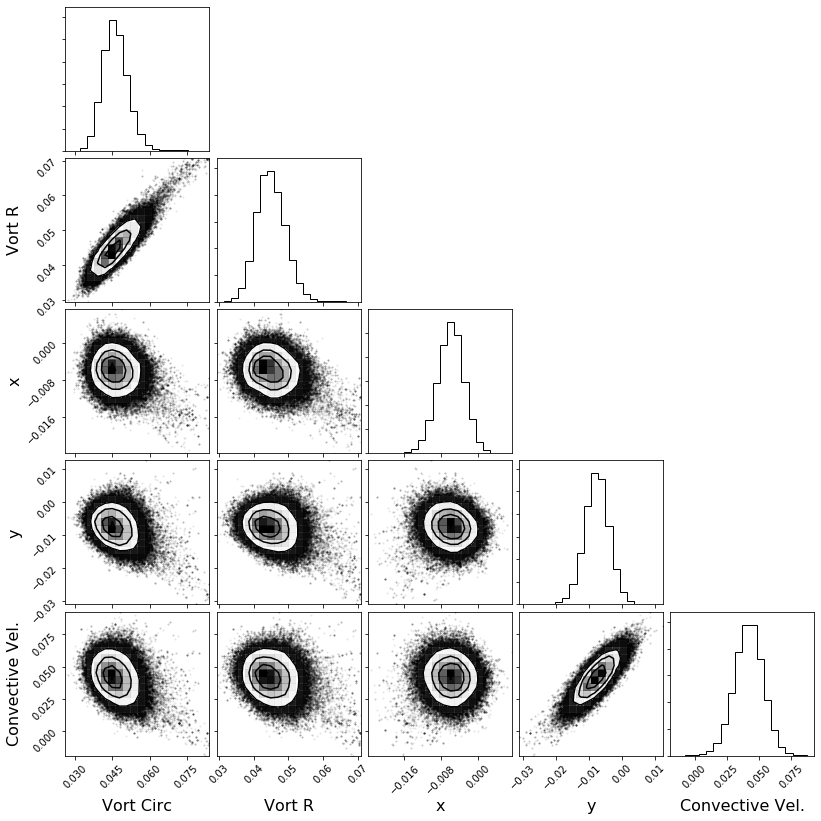

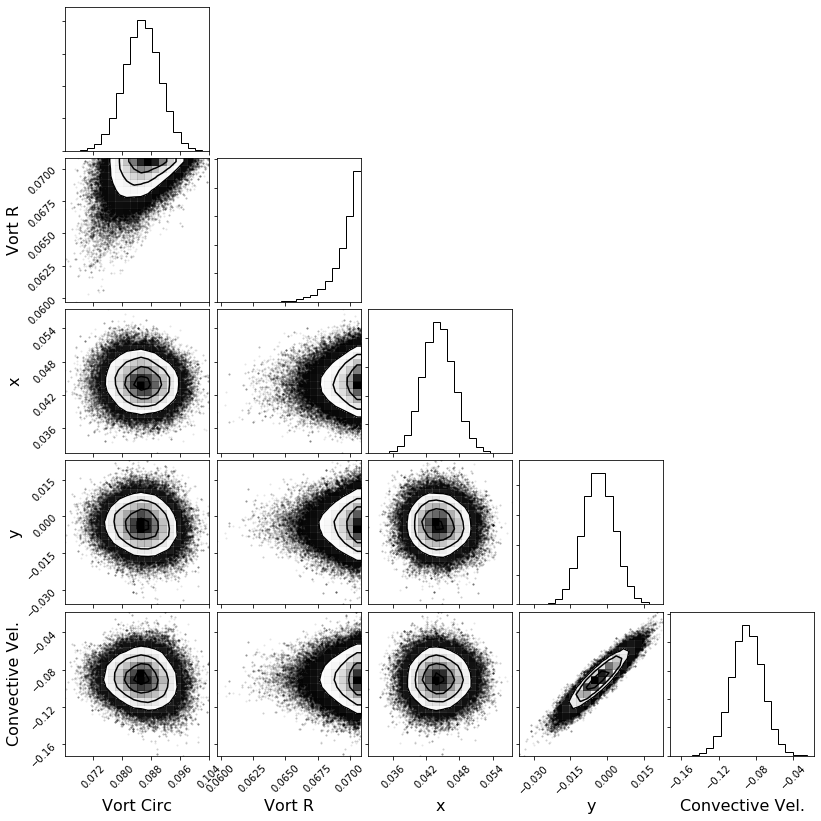

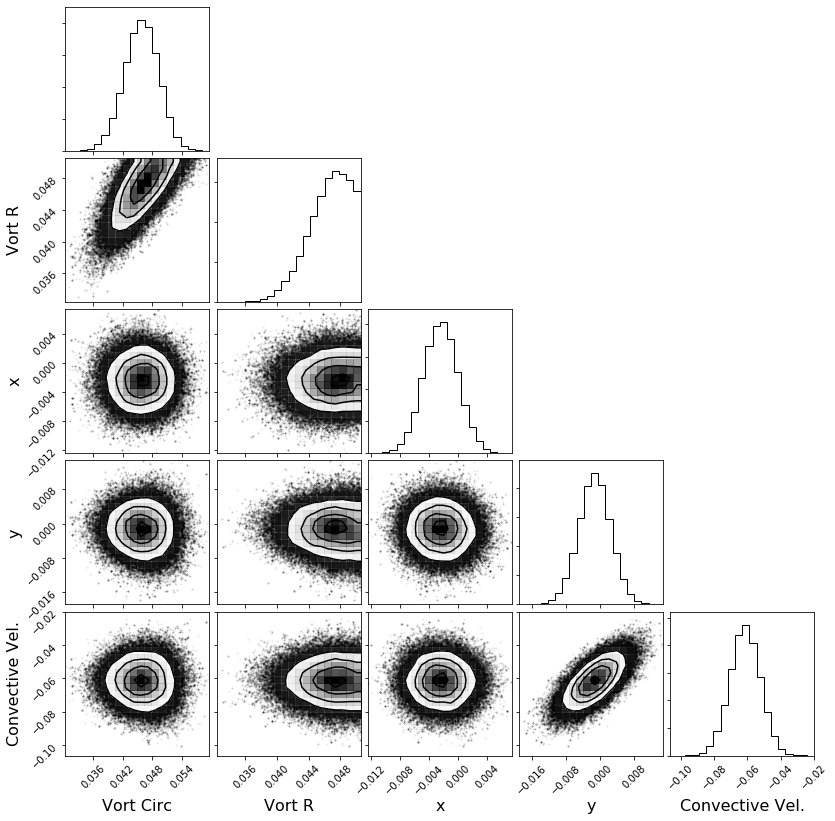

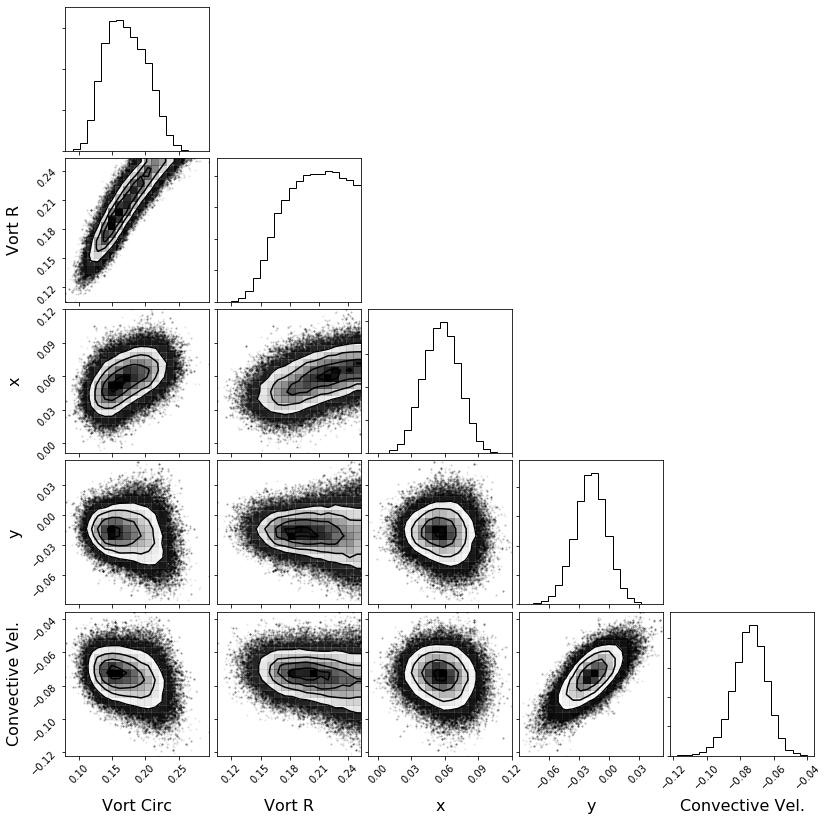

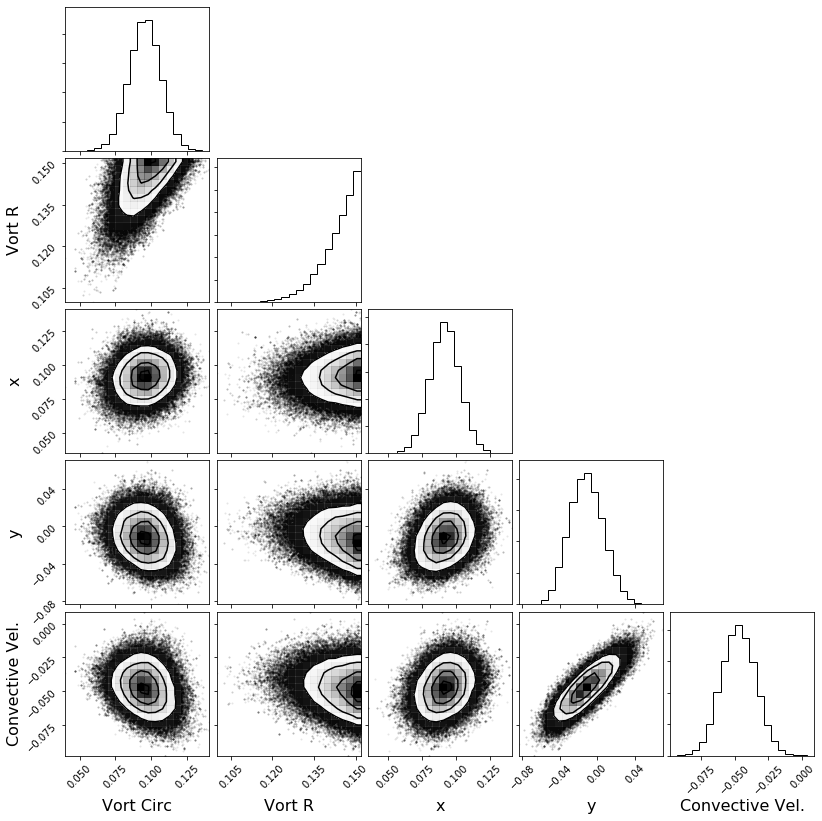

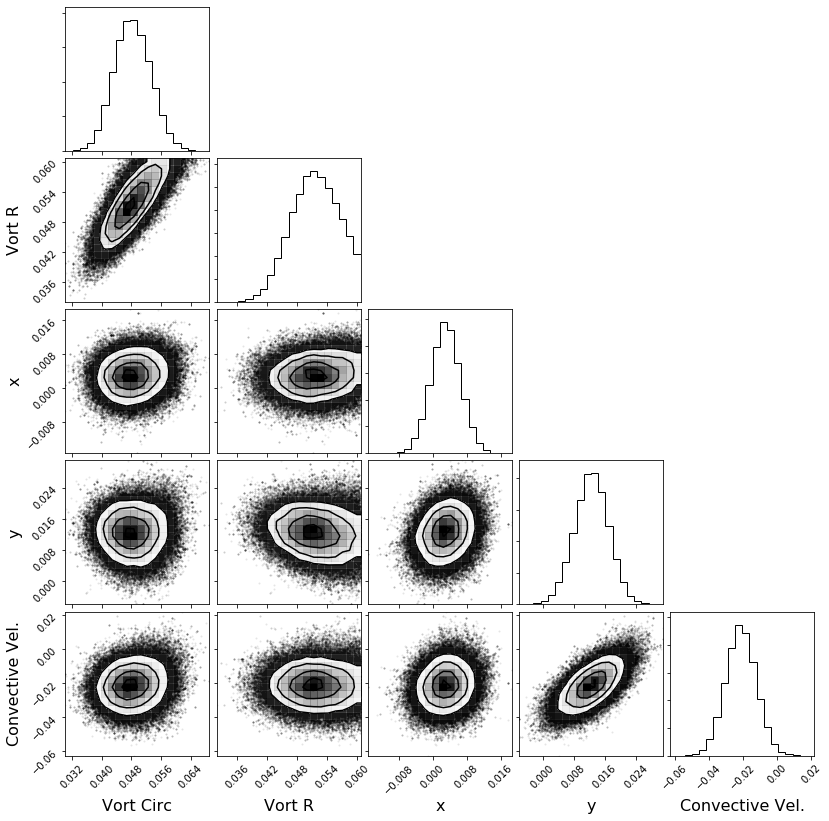

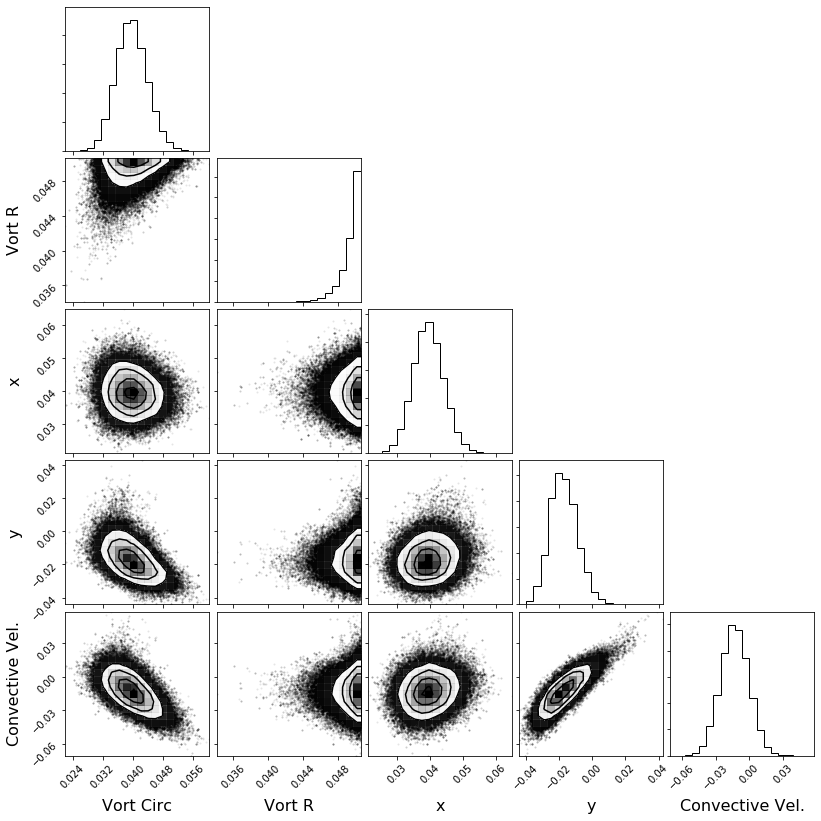

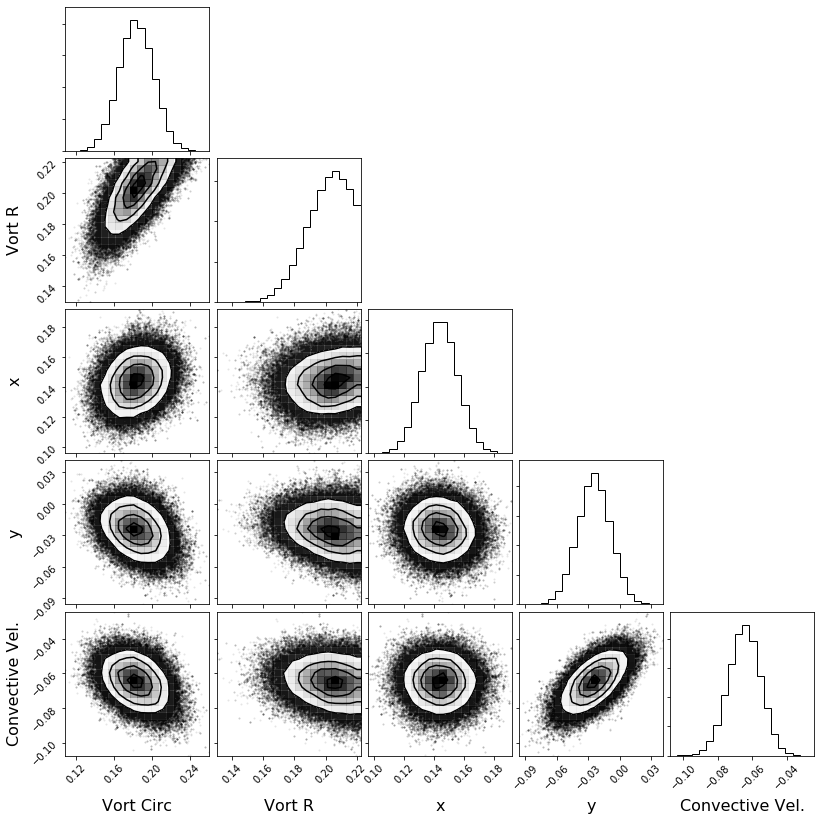

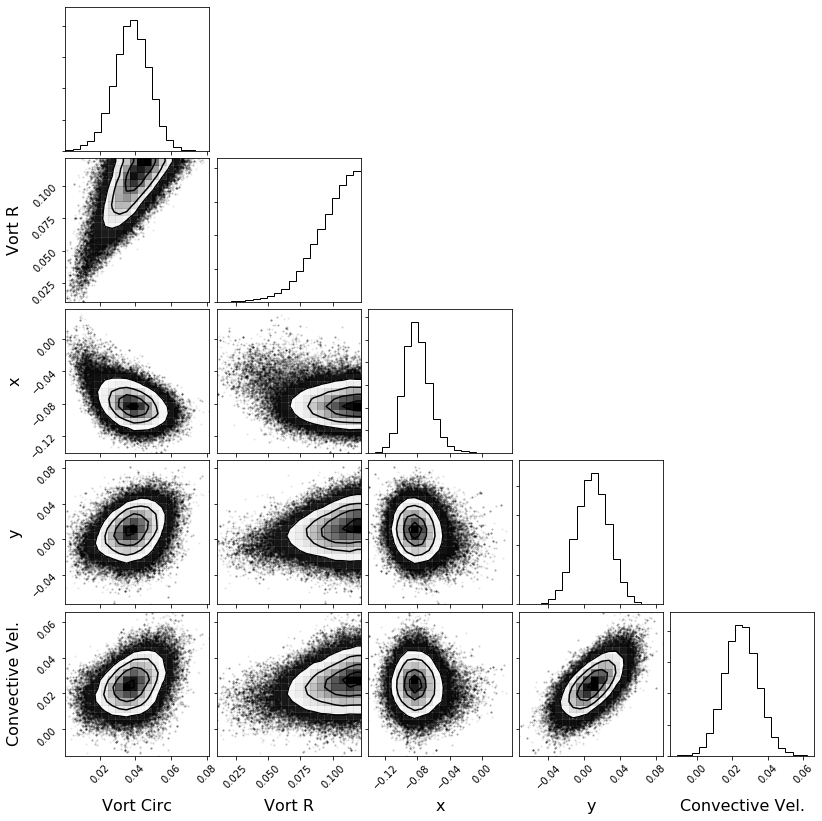

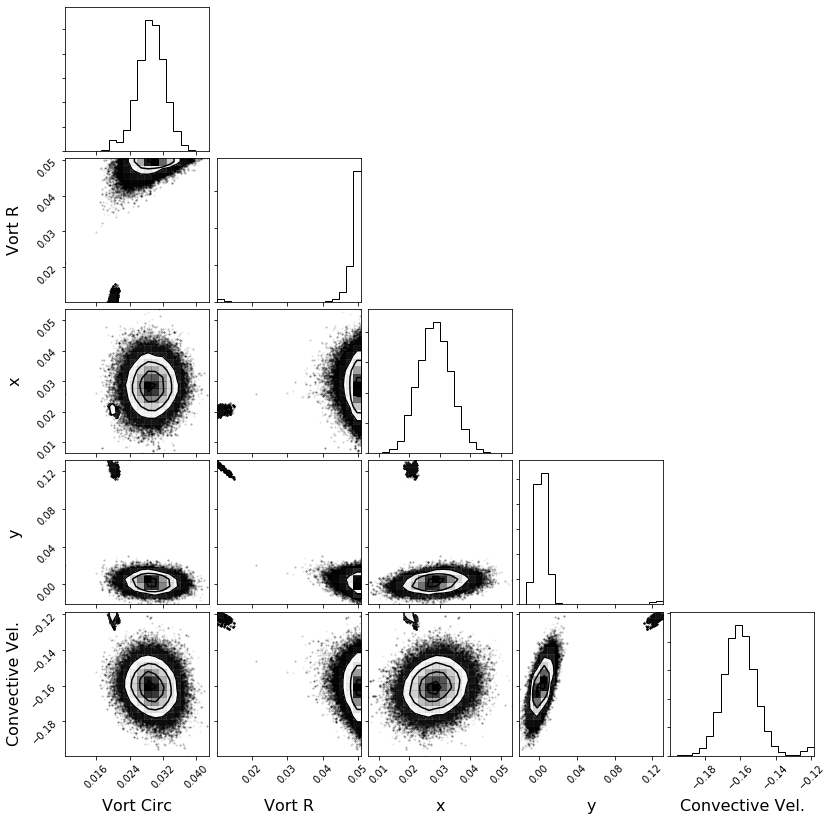

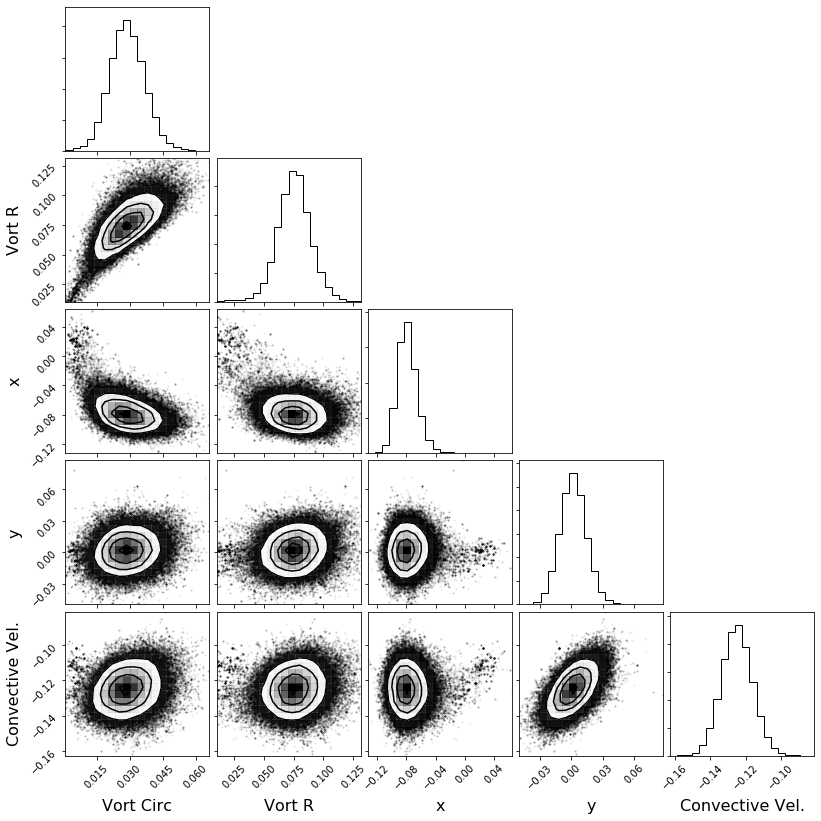

In [15]:
for samp in samps :
    G.plot_corner(samp, 5000)

### Extracting solutions from Corner plots (+ GMMs ?)

In [16]:
#even after using GMMs we only pair the pdfs with the biggest wightage together.
#so lets only extract the peak of the biggest peak in the joint pdf from corner plots.

In [17]:
def cornerSol(samp):
    sol_set = []
    from scipy.signal import find_peaks 

    s_ = samp.chain[:,5000:,:].reshape(-1,5).T
    #print(len(s_))
    for i in range(len(s_)):
        #loop over parameters

        pt = s_[i]
        y,x_ = np.histogram(pt, bins = 100)
        x = [(x_[i]+x_[i+1])/2 for i in range(len(x_)-1)]
        
        gg = find_peaks(y/np.max(y), height = 0.95 )[0] #prom = 95 (apx.)
        if len(gg) == 0: return -1 #F3 fail check
        sol_set.append(x[gg[0]])
    
    return sol_set
    

In [18]:
sol_dict = {}
for s in range(len(samps)):
    if AG.F3check(samps[s],5000, 95): 
        sol_dict[s] = -1
    else:
        sol_dict[s] = cornerSol(samps[s])

### Big Histograms of all the solutions

In [19]:
def bigHist(sol_dir):
    SS, R, X, Y, CV = [], [], [], [], []
    T = ['SS', 'R', 'X', 'Y', 'CV'] 
    for i in sol_dir.keys():
        if sol_dir[i] == -1: continue 
        se = sol_dir[i]
        SS.append(se[0])
        R.append(se[1])
        X.append(se[2])
        Y.append(se[3])
        CV.append(se[4])
    ii = 0
    for i in [SS, R, X, Y, CV]:
        plt.figure()
        a, b = np.histogram(i, bins = len(SS))
        b_  = [(b[i]+b[i+1])/2 for i in range(len(b)-1)]
        plt.plot(b_, a/np.max(a))
        plt.title(T[ii])
        ii+=1
    return
        

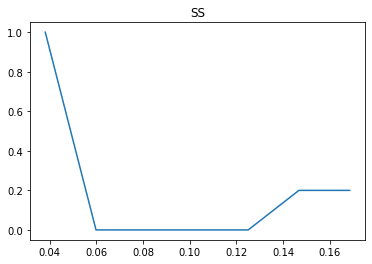

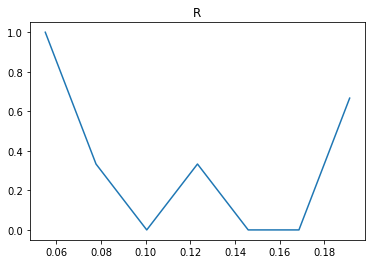

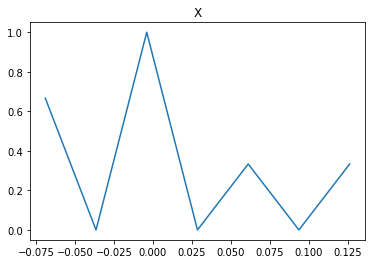

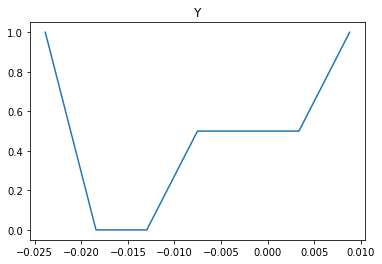

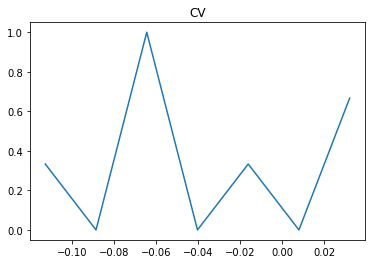

In [20]:
bigHist(sol_dict)

In [21]:
#currently this implementation takes the first frame into account.
#loop over frames , aditionally include threshold to calculate the number of vortices.

#begin draft!